In [1]:
#Adaboost presentation based from https://github.com/jaimeps/adaboost-implementation
#Input comparison of different models

import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import train_test_split
from sklearn.datasets import make_hastie_10_2
from sklearn.datasets import make_gaussian_quantiles
from sklearn import svm, metrics
import matplotlib.pyplot as plt


C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def get_error_rate(pred, Y):
    return sum(pred != Y) / float(len(Y))
def print_error_rate(err):
    print ('Error rate: Training: %.4f - Test: %.4f' % err)

In [3]:
def generic_clf(Y_train, X_train, Y_test, X_test, clf):
    clf.fit(X_train,Y_train)
    pred_train = clf.predict(X_train)
    pred_test = clf.predict(X_test)
    return get_error_rate(pred_train, Y_train), \
           get_error_rate(pred_test, Y_test)

In [4]:
""" ADABOOST IMPLEMENTATION ================================================="""
def adaboost_clf(Y_train, X_train, Y_test, X_test, M, clf):
    n_train, n_test = len(X_train), len(X_test)
    # Initialize weights
    w = np.ones(n_train) / n_train
    pred_train, pred_test = [np.zeros(n_train), np.zeros(n_test)]
    
    for i in range(M):
        # Fit a classifier with the specific weights
        clf.fit(X_train, Y_train, sample_weight = w)
        pred_train_i = clf.predict(X_train)
        pred_test_i = clf.predict(X_test)
        # Indicator function
        miss = [int(x) for x in (pred_train_i != Y_train)]
        # Equivalent with 1/-1 to update weights
        miss2 = [x if x==1 else -1 for x in miss]
        # Error
        err_m = np.dot(w,miss) / sum(w)
        # Alpha
        alpha_m = 0.5 * np.log( (1 - err_m) / float(err_m))
        # New weights
        w = np.multiply(w, np.exp([float(x) * alpha_m for x in miss2]))
        # Add to prediction
        pred_train = [sum(x) for x in zip(pred_train, 
                                          [x * alpha_m for x in pred_train_i])]
        pred_test = [sum(x) for x in zip(pred_test, 
                                         [x * alpha_m for x in pred_test_i])]
    
    pred_train, pred_test = np.sign(pred_train), np.sign(pred_test)
    # Return error rate in train and test set
    return get_error_rate(pred_train, Y_train), \
           get_error_rate(pred_test, Y_test)

In [5]:
""" PLOT FUNCTION """
def plot_error_rate(er_train, er_test):
    df_error = pd.DataFrame([er_train, er_test]).T
    df_error.columns = ['Training', 'Test']
    plot1 = df_error.plot(linewidth = 3, figsize = (8,6),
            color = ['lightblue', 'darkblue'], grid = True)
    plot1.set_xlabel('Number of iterations', fontsize = 12)
    plot1.set_xticklabels(range(0,450,50))
    plot1.set_ylabel('Error rate', fontsize = 12)
    plot1.set_title('Error rate vs number of iterations', fontsize = 16)
    plt.axhline(y=er_test[0], linewidth=1, color = 'red', ls = 'dashed')


In [6]:
# Read data
x, y = make_hastie_10_2()
#x, y = make_gaussian_quantiles()

df = pd.DataFrame(x)
df['Y'] = y

# Split into training and test set
train, test = train_test_split(df, test_size = 0.2)
X_train, Y_train = train.iloc[:,:-1], train.iloc[:,-1]
X_test, Y_test = test.iloc[:,:-1], test.iloc[:,-1]

train.head()  

,0,1,2,3,4,5,6,7,8,9,Y
8328,-2.291989,-0.818228,-0.250129,1.074255,0.755179,-0.508539,1.399699,-0.133303,-0.295135,-1.393571,1.0
9446,0.106802,0.957597,-1.030665,0.506449,1.173079,0.390962,1.587478,0.305975,-1.381199,0.600528,-1.0
8126,-1.196890,-0.712684,-0.542550,0.435575,-0.401335,1.722594,-1.391858,0.070377,-0.482903,0.085640,-1.0
8824,0.729155,0.862566,-0.827492,1.432451,-1.750154,0.257248,-0.459307,-2.308490,-0.573950,-0.334493,1.0
4372,-2.105306,2.162339,-0.413778,0.659430,0.611015,0.254253,-0.350797,-0.243703,-0.986165,-0.461223,1.0


In [7]:
# Fit a simple decision tree first
clf_tree = DecisionTreeClassifier(max_depth = 1, random_state = 1)
er_tree = generic_clf(Y_train, X_train, Y_test, X_test, clf_tree)

In [8]:
classifier = clf_tree
classifier.fit(X_train, Y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')

In [9]:
expected = Y_test
predicted = classifier.predict(X_test)
print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(expected, predicted)))

Classification report for classifier DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best'):
             precision    recall  f1-score   support

       -1.0       0.55      0.94      0.69      1255
        1.0       0.70      0.15      0.25      1145

avg / total       0.62      0.56      0.48      2400




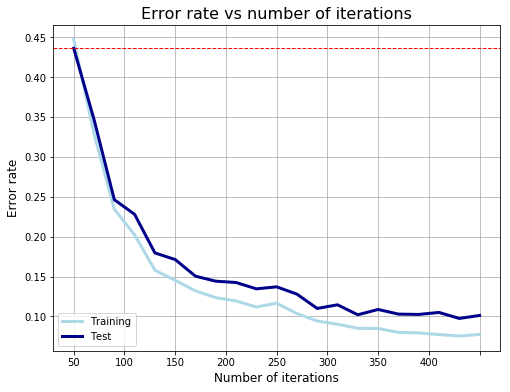

In [10]:
# Fit Adaboost classifier using a decision tree as base estimator
# Test with different number of iterations
er_train, er_test = [er_tree[0]], [er_tree[1]]
x_range = range(10, 410, 20)
for i in x_range:    
    temp = adaboost_clf(Y_train, X_train, Y_test, X_test, i, clf_tree)
    er_train.append(temp[0])
    er_test.append(temp[1])
    
    # Compare error rate vs number of iterations
plot_error_rate(er_train, er_test)

In [11]:
#standard suport vector machine

classifier = svm.SVC()
classifier.fit(X_train, Y_train)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [12]:
expected = Y_test
predicted = classifier.predict(X_test)
print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(expected, predicted)))

Classification report for classifier SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

       -1.0       0.97      0.99      0.98      1255
        1.0       0.99      0.97      0.98      1145

avg / total       0.98      0.98      0.98      2400


